## Troubleshooting

In [1]:
!pip install --upgrade numba==0.61.0
!uv pip install -q --system numba-cuda==0.4.0
!pip list | grep numba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 21.7 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninstalled numba-0.60.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml-cu12 25.2.1 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.0 which is incompatible.
dask-cuda 25.2.0 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.0 which is incompatible.
cudf-cu12 25.2.1 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.0 which is incompatible.
distributed-ucxx-cu12 0.42.0 requires numba<0.61.0a0,>=

In [2]:
# import numba_cuda as cuda
from numba import cuda
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt

from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1
config.CUDA_LOW_OCCUPANCY_WARNINGS = 0

In [3]:
# grid parameters
NUM_BLOCKS = 1024
WG_SZ = 128

## Задание 1

Выполнить распараллеливание процесса вычисления функции:

$f: \varnothing \rightarrow R^n$

$f(n) = \cos(\arctan(n^2))$

In [4]:
@cuda.jit
def f1(x):
  n = cuda.grid(1)
  x[n] = math.cos(math.atan(n**2))

In [ ]:
# num_repetitions = 100
# array_sz = [2**i for i in range(0,11,1)]
# times_np = np.zeros(len(array_sz), dtype=np.float64)
# times_cuda = np.zeros(len(array_sz), dtype=np.float64)

# x = cuda.device_array(1024, dtype=np.float64)
# %timeit f1[(NUM_BLOCKS,), (WG_SZ,)](x)
# %timeit np.cos(np.atan(np.arange(0, 1024) ** 2))
# print(x.copy_to_host()[:10])

In [ ]:
# x_test_cuda = cuda.device_array(array_sz[-1], dtype=np.float64)
# print("Ref result: ", np.cos(np.atan(np.arange(0, 4) ** 2)))
# for i, sz in enumerate(array_sz):
#   x_test_np = np.arange(sz, dtype=np.float64)
#   print("Calculating size=", sz)
#   times_cuda[i] = timeit.timeit(stmt='f1[(sz,), (wg_sz,)](x_test_cuda)',
#                               globals={"f1": f1, "sz": sz, "wg_sz": WG_SZ,
#                                        "x_test_cuda": x_test_cuda},
#                               number=num_repetitions)
#   print(x_test_cuda.copy_to_host()[:4])
#   times_np[i] = timeit.timeit(stmt='cos(atan(x_test_np ** 2))',
#                             globals={"cos": np.cos, "atan": np.atan,
#                                       "x_test_np": x_test_np},
#                             number=num_repetitions)

# plt.plot(array_sz ,times_cuda)
# plt.plot(array_sz, times_np)
# plt.xscale('log')

In [5]:
sz = 4096
arr_n = np.empty(sz, dtype=np.float32)
f1[(NUM_BLOCKS,), (WG_SZ,)](arr_n)
ref_data = np.cos(np.arctan(np.arange(sz, dtype=np.float32)**2))

/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/devicearray.py:893: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [8]:
ref_data[-1]

np.float32(7.54979e-08)

In [9]:
arr_n[-1]

np.float32(5.963376e-08)

In [10]:
max_err = np.empty(sz, dtype=np.float32)
mean_err = np.empty(sz, dtype=np.float32)
for i in range(0, ref_data.shape[0]):
  max_err[i] = np.max(np.abs(((ref_data-arr_n))[:(i+1)]))
  mean_err[i] = np.mean(np.abs(((ref_data-arr_n))[:(i+1)]))

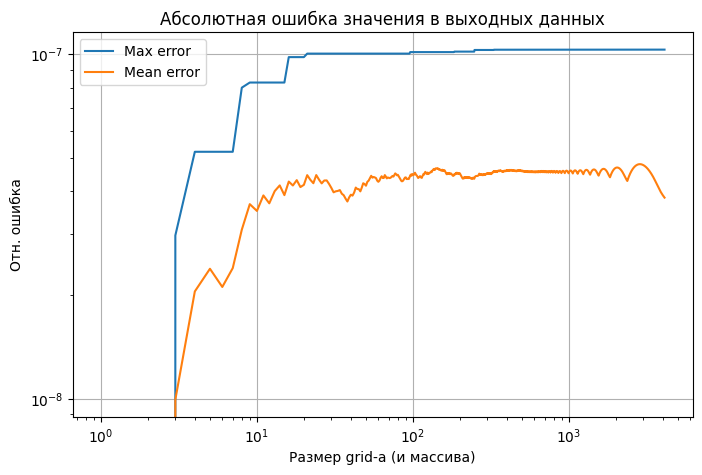

In [13]:
fig1 = plt.figure(figsize=[8,5])
ax_1 = fig1.add_subplot(111)
ax_1.set_title(r'Абсолютная ошибка значения в выходных данных')
ax_1.plot(np.arange(1, ref_data.shape[0]+1), max_err, label='Max error')
ax_1.plot(np.arange(1, ref_data.shape[0]+1), mean_err, label='Mean error')
ax_1.set_xlabel('Размер grid-а (и массива)')
ax_1.set_ylabel('Отн. ошибка')
ax_1.set_xscale('log')
ax_1.set_yscale('log')
ax_1.grid()
ax_1.legend()
plt.show()

## Задание 2

Распараллелить процесс покоординатного произведения:

$f: R^{3n}\times R^{3n} \rightarrow R^{3n}$

$f(x, y)=x\times y$

In [14]:
@cuda.jit
def cross_prod_naive(x, y, z):
  n = cuda.grid(1)
  z[n, 0] = x[n,1] * y[n,2] - x[n,2] * y[n,1]
  z[n, 1] = x[n,2] * y[n,0] - x[n,0] * y[n,2]
  z[n, 2] = x[n,0] * y[n,1] - x[n,1] * y[n,0]

@cuda.jit
def cross_prod_2dparallel(x, y, z):
  i, n = cuda.grid(2) # FIRST IDX - FASTEST DIMENSION
  # z[n, i] = x[n, (i+1)%3] * y[n, (i+2)%3] - x[n, (i+2)%3] * y[n, (i+1)%3]
  z[n, i] = x[n, i]*y[n, i]

Первый запуск (проверка)

In [ ]:
vecs_x = np.array([[1, 2, 3], [4, 5, 6]], dtype=np.float32)
vecs_y = np.array([[1, -1, 1], [1, -1, 1]], dtype=np.float32)

vecs_x_da = cuda.to_device(vecs_x)
vecs_y_da = cuda.to_device(vecs_y)
vecs_z_da1 = cuda.device_array_like(vecs_x)
vecs_z_da2 = cuda.device_array_like(vecs_x)

cross_prod_2dparallel[(32,32,), (32,32,)](vecs_x_da, vecs_y_da, vecs_z_da1)
print(vecs_z_da1.copy_to_host())

cross_prod_naive[(1,), (32,)](vecs_x_da, vecs_y_da, vecs_z_da2)
print(vecs_z_da2.copy_to_host())

Смотрим ошибку

In [15]:
n_vecs = 4096
vecs1 = np.reshape(np.random.rand(n_vecs*3).astype(np.float32), (n_vecs, 3))
vecs2 = np.reshape(np.random.rand(n_vecs*3).astype(np.float32), (n_vecs, 3))
vecs_out1 = np.empty_like(vecs1)
vecs_out2 = np.empty_like(vecs1)

In [16]:
# cross_prod_2dparallel[(16,16), (128,128)](vecs1, vecs2, vecs_out1)
# print(vecs_out1)

cross_prod_naive[(NUM_BLOCKS,), (WG_SZ,)](vecs1, vecs2, vecs_out2)
print(vecs_out2[:2])

ref_values = np.cross(vecs1, vecs2, axis=1)
print(ref_values[:2])

[[ 0.09422981  0.32352653 -0.11031171]
 [ 0.2910362   0.08012874 -0.513078  ]]
[[ 0.09422981  0.32352653 -0.11031171]
 [ 0.2910362   0.08012874 -0.513078  ]]


/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/devicearray.py:893: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [17]:
max_err = np.empty(n_vecs, dtype=np.float32)
mean_err = np.empty(n_vecs, dtype=np.float32)
for i in range(0, ref_values.shape[0]):
  max_err[i] = np.max(np.abs(((ref_values-vecs_out2) / ref_values)[:(i+1)]))
  mean_err[i] = np.mean(np.abs(((ref_values-vecs_out2) / ref_values)[:(i+1)]))

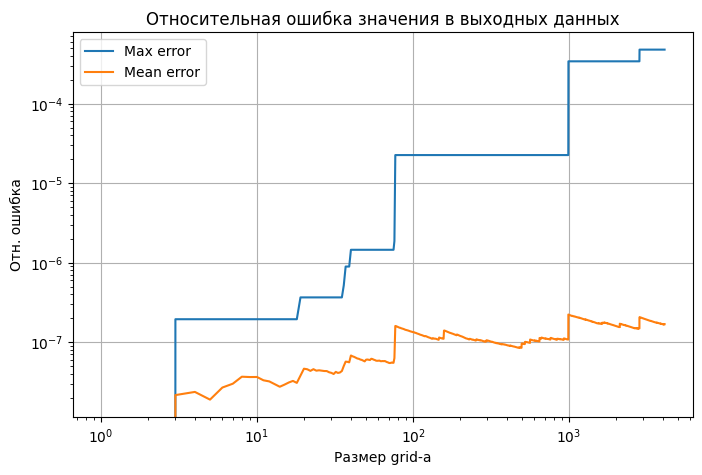

In [18]:
fig2 = plt.figure(figsize=[8,5])
ax_1 = fig2.add_subplot(111)
ax_1.set_title(r'Относительная ошибка значения в выходных данных')
ax_1.plot(np.arange(1, ref_values.shape[0]+1), max_err, label='Max error')
ax_1.plot(np.arange(1, ref_values.shape[0]+1), mean_err, label='Mean error')
ax_1.set_xlabel('Размер grid-а')
ax_1.set_ylabel('Отн. ошибка')
ax_1.set_xscale('log')
ax_1.set_yscale('log')
ax_1.grid()
ax_1.legend()
plt.show()

## Задание 3

Распараллелить процесс вычисления 2-й производной (численнной):

$f\approx \frac{d^2}{dx^2}: R^N → R^N$

$f(x)_n=x_{n+1}-2x_n+x_{n-1}$

2 варианта действия на границах:

1. $n \rightarrow n \mod N$
2. $f: R^N \rightarrow R^{N-2}$

In [19]:
@cuda.jit
def deriv_red(x, dx):
  n = cuda.grid(1)
  if (1 <= n < dx.shape[0]):
    dx[n] = x[n+1] + x[n-1] - 2 * x[n]

@cuda.jit
def deriv_cycl(x, dx):
  n = cuda.grid(1)
  N = x.shape[0]
  dx[n] = x[(n+1)%N] + x[(n-1)%N] - 2 * x[n]

In [20]:
n_elems = 4096
x = np.random.rand(1024).astype(np.float32)
dx_red_full = np.empty_like(x)
dx_cycl = np.empty_like(x)

In [21]:
deriv_red[(NUM_BLOCKS,), (WG_SZ,)](x, dx_red_full)
dx_red = dx_red_full[1:-1]
ref_dx_red = np.diff(np.diff(x))
deriv_cycl[(NUM_BLOCKS,), (WG_SZ,)](x, dx_cycl)
ref_dx_cycl = np.diff(np.diff(np.concatenate(([x[-1]], x, [x[0]]))))
print(dx_red[:2])
print(ref_dx_red[:2])
print(dx_cycl[:2])
print(ref_dx_cycl[:2])

[0.0948298 0.3909604]
[0.09482977 0.3909604 ]
[-0.39310157  0.0948298 ]
[-0.39310157  0.09482977]


/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/devicearray.py:893: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/devicearray.py:893: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [22]:
max_err_red = np.empty(n_elems-2, dtype=np.float32)
mean_err_red = np.empty(n_elems-2, dtype=np.float32)
max_err_cycl = np.empty(n_elems, dtype=np.float32)
mean_err_cycl = np.empty(n_elems, dtype=np.float32)
for i in range(0, ref_values.shape[0]):
  if i < ref_values.shape[0] - 2:
    max_err_red[i] = np.max(np.abs(((ref_dx_red-dx_red) / ref_dx_red)[:(i+1)]))
    mean_err_red[i] = np.mean(np.abs(((ref_dx_red-dx_red) / ref_dx_red)[:(i+1)]))

  max_err_cycl[i] = np.max(np.abs(((ref_dx_cycl-dx_cycl) / ref_dx_cycl)[:(i+1)]))
  mean_err_cycl[i] = np.mean(np.abs(((ref_dx_cycl-dx_cycl) / ref_dx_cycl)[:(i+1)]))

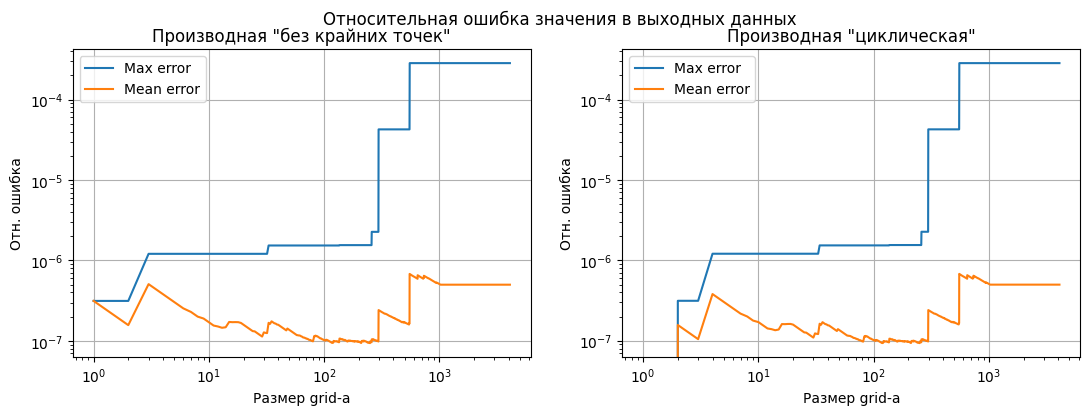

In [23]:
fig3 = plt.figure(figsize=[13,4])
fig3.suptitle(r'Относительная ошибка значения в выходных данных')

ax_1 = fig3.add_subplot(121)
ax_1.set_title('Производная \"без крайних точек\"')
ax_1.plot(np.arange(1, ref_values.shape[0]-1), max_err_red, label='Max error')
ax_1.plot(np.arange(1, ref_values.shape[0]-1), mean_err_red, label='Mean error')
ax_1.set_xlabel('Размер grid-а')
ax_1.set_ylabel('Отн. ошибка')
ax_1.set_xscale('log')
ax_1.set_yscale('log')
ax_1.grid()
ax_1.legend()

ax_2 = fig3.add_subplot(122)
ax_2.set_title('Производная \"циклическая\"')
ax_2.plot(np.arange(1, ref_values.shape[0]+1), max_err_cycl, label='Max error')
ax_2.plot(np.arange(1, ref_values.shape[0]+1), mean_err_cycl, label='Mean error')
ax_2.set_xlabel('Размер grid-а')
ax_2.set_ylabel('Отн. ошибка')
ax_2.set_xscale('log')
ax_2.set_yscale('log')
ax_2.grid()
ax_2.legend()

plt.show()

## Задание 4

Распареллелить вычисление следующей функции (типа reduce):

1. $f: R^N \rightarrow R$

  $f(x)=\displaystyle\sum_{n=0}^{N-1} x_n$
2. $f: R^N\times R^N \rightarrow R$

  $f(x, y)=\displaystyle\sum_{n=0}^{N-1} x_n y_n$

In [24]:
@cuda.jit
def parallel_sum_core_single(arr, partial_sums):
    shared = cuda.shared.array(1024, dtype=np.float32)
    tid = cuda.threadIdx.x
    i = cuda.grid(1)

    if i < len(arr):
        shared[tid] = arr[i]
    else:
        shared[tid] = 0.0

    cuda.syncthreads()
    # cuda.synchronize()

    s = cuda.blockDim.x // 2
    while s > 0:
        if tid < s:
            shared[tid] += shared[tid + s]
        cuda.syncthreads()
        # cuda.synchronize()
        s //= 2

    if tid == 0:
        partial_sums[cuda.blockIdx.x] = shared[0]

def parallel_sum_single(arr):
    arr = np.asarray(arr, dtype=np.float32)
    n = len(arr)

    threads_per_block = 4
    blocks_per_grid = (n + threads_per_block - 1) // threads_per_block

    d_arr = cuda.to_device(arr)
    d_partial_sums = cuda.device_array(blocks_per_grid, dtype=np.float32)

    parallel_sum_core_single[blocks_per_grid, threads_per_block](d_arr, d_partial_sums)

    partial_sums = d_partial_sums.copy_to_host()
    total_sum = np.sum(partial_sums)

    return total_sum

In [25]:
@cuda.jit
def parallel_sum_core_2arr(arr1, arr2, partial_sums):
    shared = cuda.shared.array(1024, dtype=np.float32)
    tid = cuda.threadIdx.x
    i = cuda.grid(1)

    if i < len(arr1):
        shared[tid] = arr1[i] * arr2[i]
    else:
        shared[tid] = 0.0

    cuda.syncthreads()
    # cuda.synchronize()

    s = cuda.blockDim.x // 2
    while s > 0:
        if tid < s:
            shared[tid] += shared[tid + s]
        cuda.syncthreads()
        # cuda.synchronize()
        s //= 2

    if tid == 0:
        partial_sums[cuda.blockIdx.x] = shared[0]

def parallel_sum_2arr(arr1, arr2):
    arr1 = np.asarray(arr1, dtype=np.float32)
    arr2 = np.asarray(arr2, dtype=np.float32)
    n = len(arr1)

    threads_per_block = 1024
    blocks_per_grid = (n + threads_per_block - 1) // threads_per_block

    d_arr1 = cuda.to_device(arr1)
    d_arr2 = cuda.to_device(arr2)
    d_partial_sums = cuda.device_array(blocks_per_grid, dtype=np.float32)

    parallel_sum_core_2arr[blocks_per_grid, threads_per_block](d_arr1, d_arr2, d_partial_sums)

    partial_sums = d_partial_sums.copy_to_host()
    total_sum = np.sum(partial_sums)

    return total_sum

In [26]:
a = np.arange(12)
parallel_sum_single(a)

np.float32(66.0)

In [27]:
a = np.arange(12)
b = np.arange(12)
parallel_sum_2arr(a, b)

np.float32(506.0)

In [28]:
num_elems = np.logspace(1, 5, 100, dtype=np.int32)
rel_err_single = np.empty(num_elems.shape, dtype=np.float32)
rel_err_two = np.empty(num_elems.shape, dtype=np.float32)
a = np.random.rand(num_elems[-1]).astype(np.float32) + 0.1
b = np.random.rand(num_elems[-1]).astype(np.float32) + 0.1

In [29]:
for i in range(num_elems.shape[0]):
  cuda_sum_single = parallel_sum_single(a[:num_elems[i]])
  ref_sum_single = np.sum(a[:num_elems[i]])
  rel_err_single[i] = np.abs((ref_sum_single - cuda_sum_single) / ref_sum_single)

  cuda_sum_two = parallel_sum_2arr(a[:num_elems[i]], b[:num_elems[i]])
  ref_sum_two = np.sum(a[:num_elems[i]]*b[:num_elems[i]])
  rel_err_two[i] = np.abs((ref_sum_two - cuda_sum_two) / ref_sum_two)

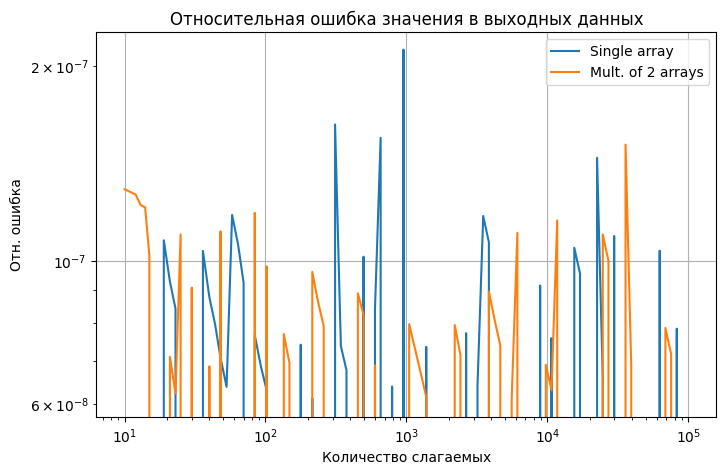

In [30]:
fig2 = plt.figure(figsize=[8,5])
ax_1 = fig2.add_subplot(111)
ax_1.set_title(r'Относительная ошибка значения в выходных данных')
ax_1.plot(num_elems, rel_err_single, label='Single array')
ax_1.plot(num_elems, rel_err_two, label='Mult. of 2 arrays')
ax_1.set_xlabel('Количество слагаемых')
ax_1.set_ylabel('Отн. ошибка')
ax_1.set_xscale('log')
ax_1.set_yscale('log')
ax_1.grid()
ax_1.legend()
plt.show()

## Задание 5

Распараллелить матричное умножение:

$C=A\cdot B$

$C_{n,m}=\displaystyle\sum_{k=1}^K A_{n,k}B_{k,m}$

In [31]:
@cuda.jit
def matmul_parallel(in_mtrx1, in_mtrx2, out_mtrx):
  k_sz = in_mtrx1.shape[1]
  n, m = cuda.grid(2)
  if n < in_mtrx1.shape[0]:
    if m < in_mtrx2.shape[1]:
      out_mtrx[n, m] = 0
      for k in range(k_sz):
        out_mtrx[n, m] += in_mtrx1[n, k] * in_mtrx2[k, m]

In [32]:
A = np.array([[1, 2], [3, 4]], dtype=np.float32)
B = np.array([[1, 1], [1, -1]], dtype=np.float32)
C = np.empty((A.shape[0], B.shape[1]), dtype=np.float32)

In [33]:
matmul_parallel[(NUM_BLOCKS, NUM_BLOCKS), (32, 32)](A, B, C)
print(C)

[[ 3. -1.]
 [ 7. -1.]]


/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/devicearray.py:893: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [34]:
num_elems = np.logspace(1, 3, 100, dtype=np.int32)
mean_rel_err = np.empty(num_elems.shape, dtype=np.float32)
max_rel_err = np.empty(num_elems.shape, dtype=np.float32)
A = np.random.rand(num_elems[-1]**2).astype(np.float32).reshape((num_elems[-1], num_elems[-1])) + 0.1
B = np.random.rand(num_elems[-1]**2).astype(np.float32).reshape((num_elems[-1], num_elems[-1])) + 0.1

In [39]:
for i in range(num_elems.shape[0]):
  A_red = np.ascontiguousarray(A[:num_elems[i], :num_elems[i]])
  B_red = np.ascontiguousarray(B[:num_elems[i], :num_elems[i]])
  C = np.empty_like(A_red)
  matmul_parallel[(NUM_BLOCKS, NUM_BLOCKS), (32, 32)](A_red, B_red, C)
  C_ref = np.matmul(A_red, B_red)
  mean_rel_err[i] = np.mean(np.abs((C - C_ref) / C_ref))
  max_rel_err[i] = np.max(np.abs((C - C_ref) / C_ref))

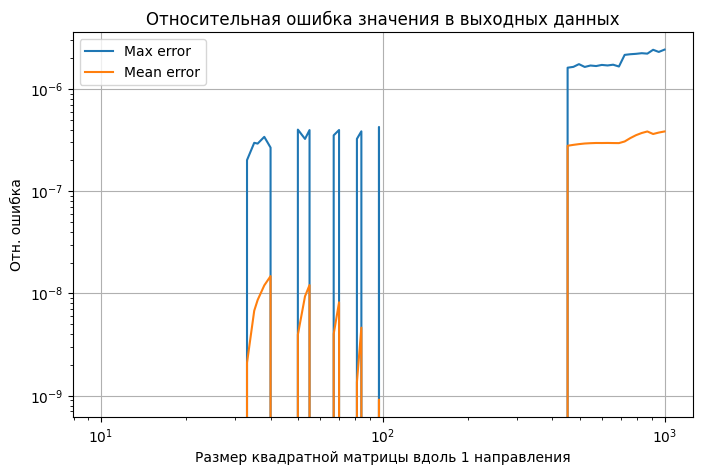

In [40]:
fig2 = plt.figure(figsize=[8,5])
ax_1 = fig2.add_subplot(111)
ax_1.set_title(r'Относительная ошибка значения в выходных данных')
ax_1.plot(num_elems, max_rel_err, label='Max error')
ax_1.plot(num_elems, mean_rel_err, label='Mean error')
ax_1.set_xlabel('Размер квадратной матрицы вдоль 1 направления')
ax_1.set_ylabel('Отн. ошибка')
ax_1.set_xscale('log')
ax_1.set_yscale('log')
ax_1.grid()
ax_1.legend()
plt.show()